In [ ]:
import os
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/colab-env')

In [2]:
import random
import gc

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(10, 7)})
sns.set_palette(sns.color_palette('muted'))

In [128]:
backtest = pd.read_csv('bybit-ma-1-leverage-result.csv')[['openPrice', 'closePrice', 'uniformPnl']]
backtest

,openPrice,closePrice,uniformPnl
0,13864.9800,14299.0100,0.488401
1,986.6400,1141.9000,2.589373
2,15040.0000,16386.0000,1.458245
3,15800.0100,14170.3800,1.883376
4,970.1100,1059.9300,-1.445691
...,...,...,...
1024,23204.7400,23191.2000,-0.043058
1025,1602.7000,1577.2600,-0.297887
1026,1644.3900,1618.1400,-0.299389
1027,0.3908,0.3784,0.512826


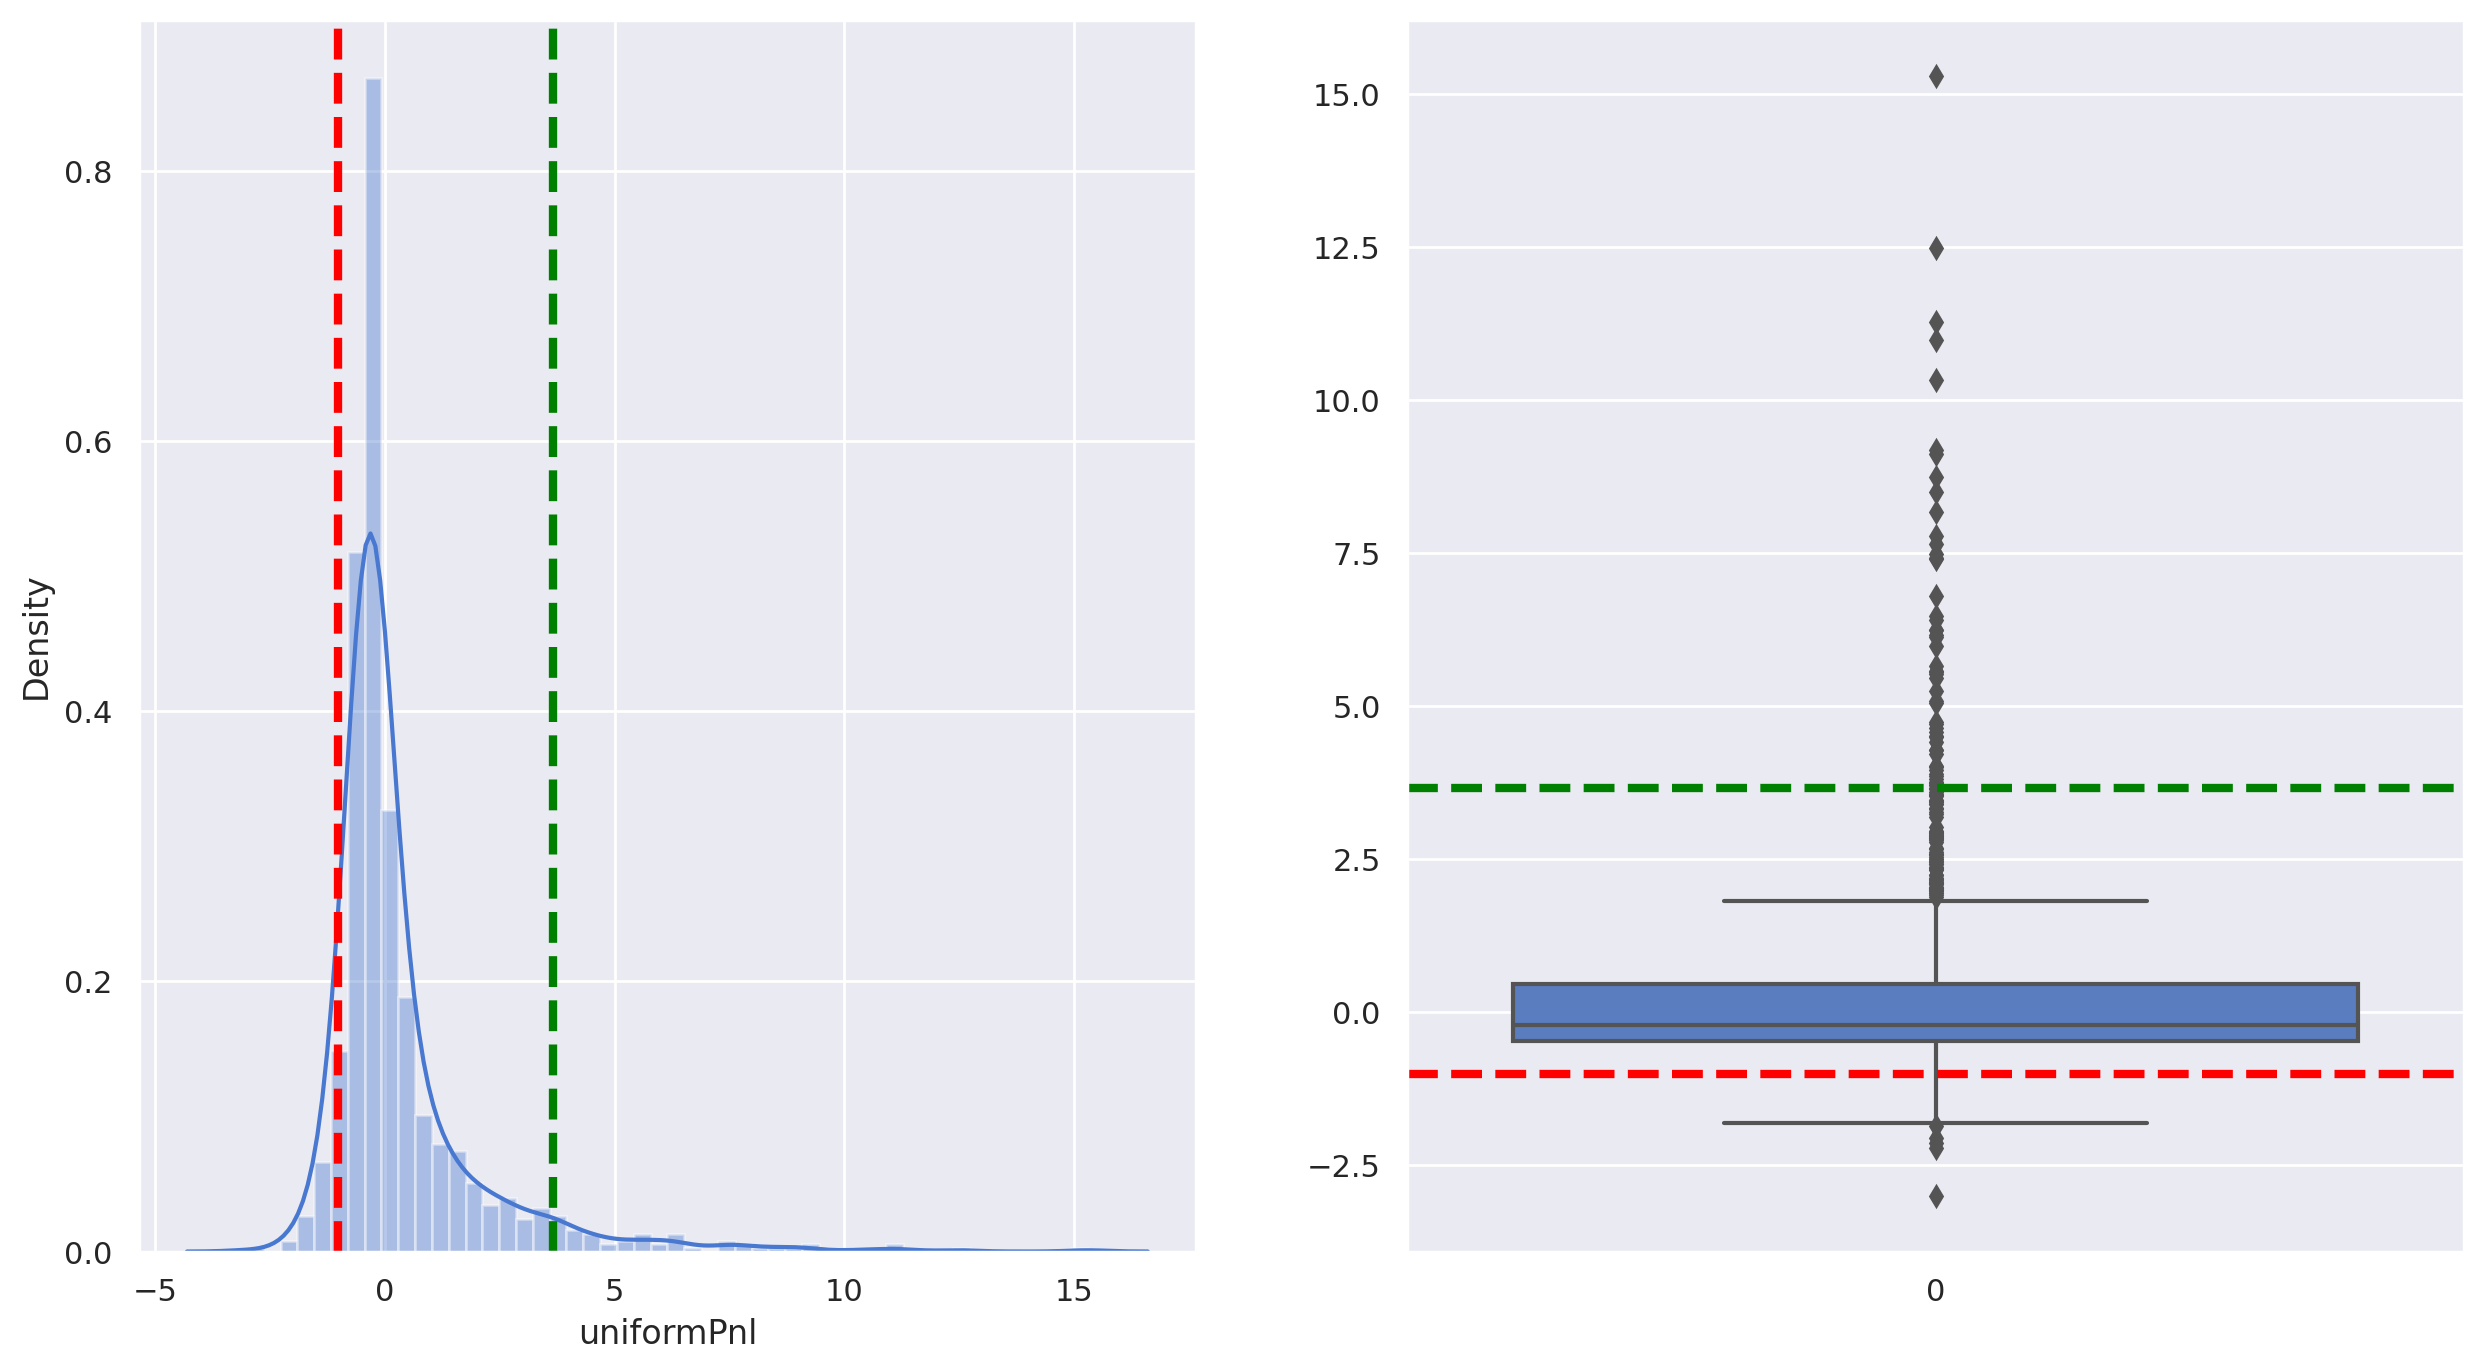

In [129]:
ql, qr = backtest['uniformPnl'].quantile(.05), backtest['uniformPnl'].quantile(.95)
fig, (ax, bx) = plt.subplots(1, 2, figsize=(15, 8))
sns.distplot(backtest['uniformPnl'], ax=ax)
ax.axvline(ql, color='red', linewidth=3, linestyle='--')
ax.axvline(qr, color='green', linewidth=3, linestyle='--')
sns.boxplot(backtest['uniformPnl'], ax=bx)
bx.axhline(ql, color='red', linewidth=3, linestyle='--')
_ = bx.axhline(qr, color='green', linewidth=3, linestyle='--')

In [117]:
def _seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def _cut(series):
  _series = series.copy()
  return _series[(_series > _series.quantile(0.00001)) & (_series < _series.quantile(0.95))]

def var(series, significance):
  return round(np.percentile(series, significance), 3)

def discretize(series, bins):
  _series = series.copy()
  linbins = np.linspace(_series.min(), _series.max(), bins)
  binned = pd.cut(
    _series,
    bins=linbins,
    include_lowest=True
  )
  intervals = pd.DataFrame(binned.value_counts()).reset_index().rename(columns={"index": "interval", _series.name: "n"})
  intervals = intervals[intervals['n'] != 0].reset_index(drop=True)
  intervals['p'] = intervals['n'] / len(_series)

  assert round(intervals['p'].sum(), 1) == 1
  return intervals

def simulate(series, M, bins, significance, cutdist=False):
  _series = series.copy()
  
  if cutdist:
    _series = _cut(_series)
  
  intervals = discretize(series=_series, bins=bins)
  probabilities = intervals['p']
  St = []
  for m in range(M):
    outcomes = intervals['interval'].apply(lambda x: np.random.uniform(low=x.left, high=x.right)).to_numpy()
    St.append(np.random.choice(a=outcomes, size=len(_series), p=probabilities).cumsum(0))

  St = np.array(St).T
  return St, var(St[-1, :], significance=significance) 

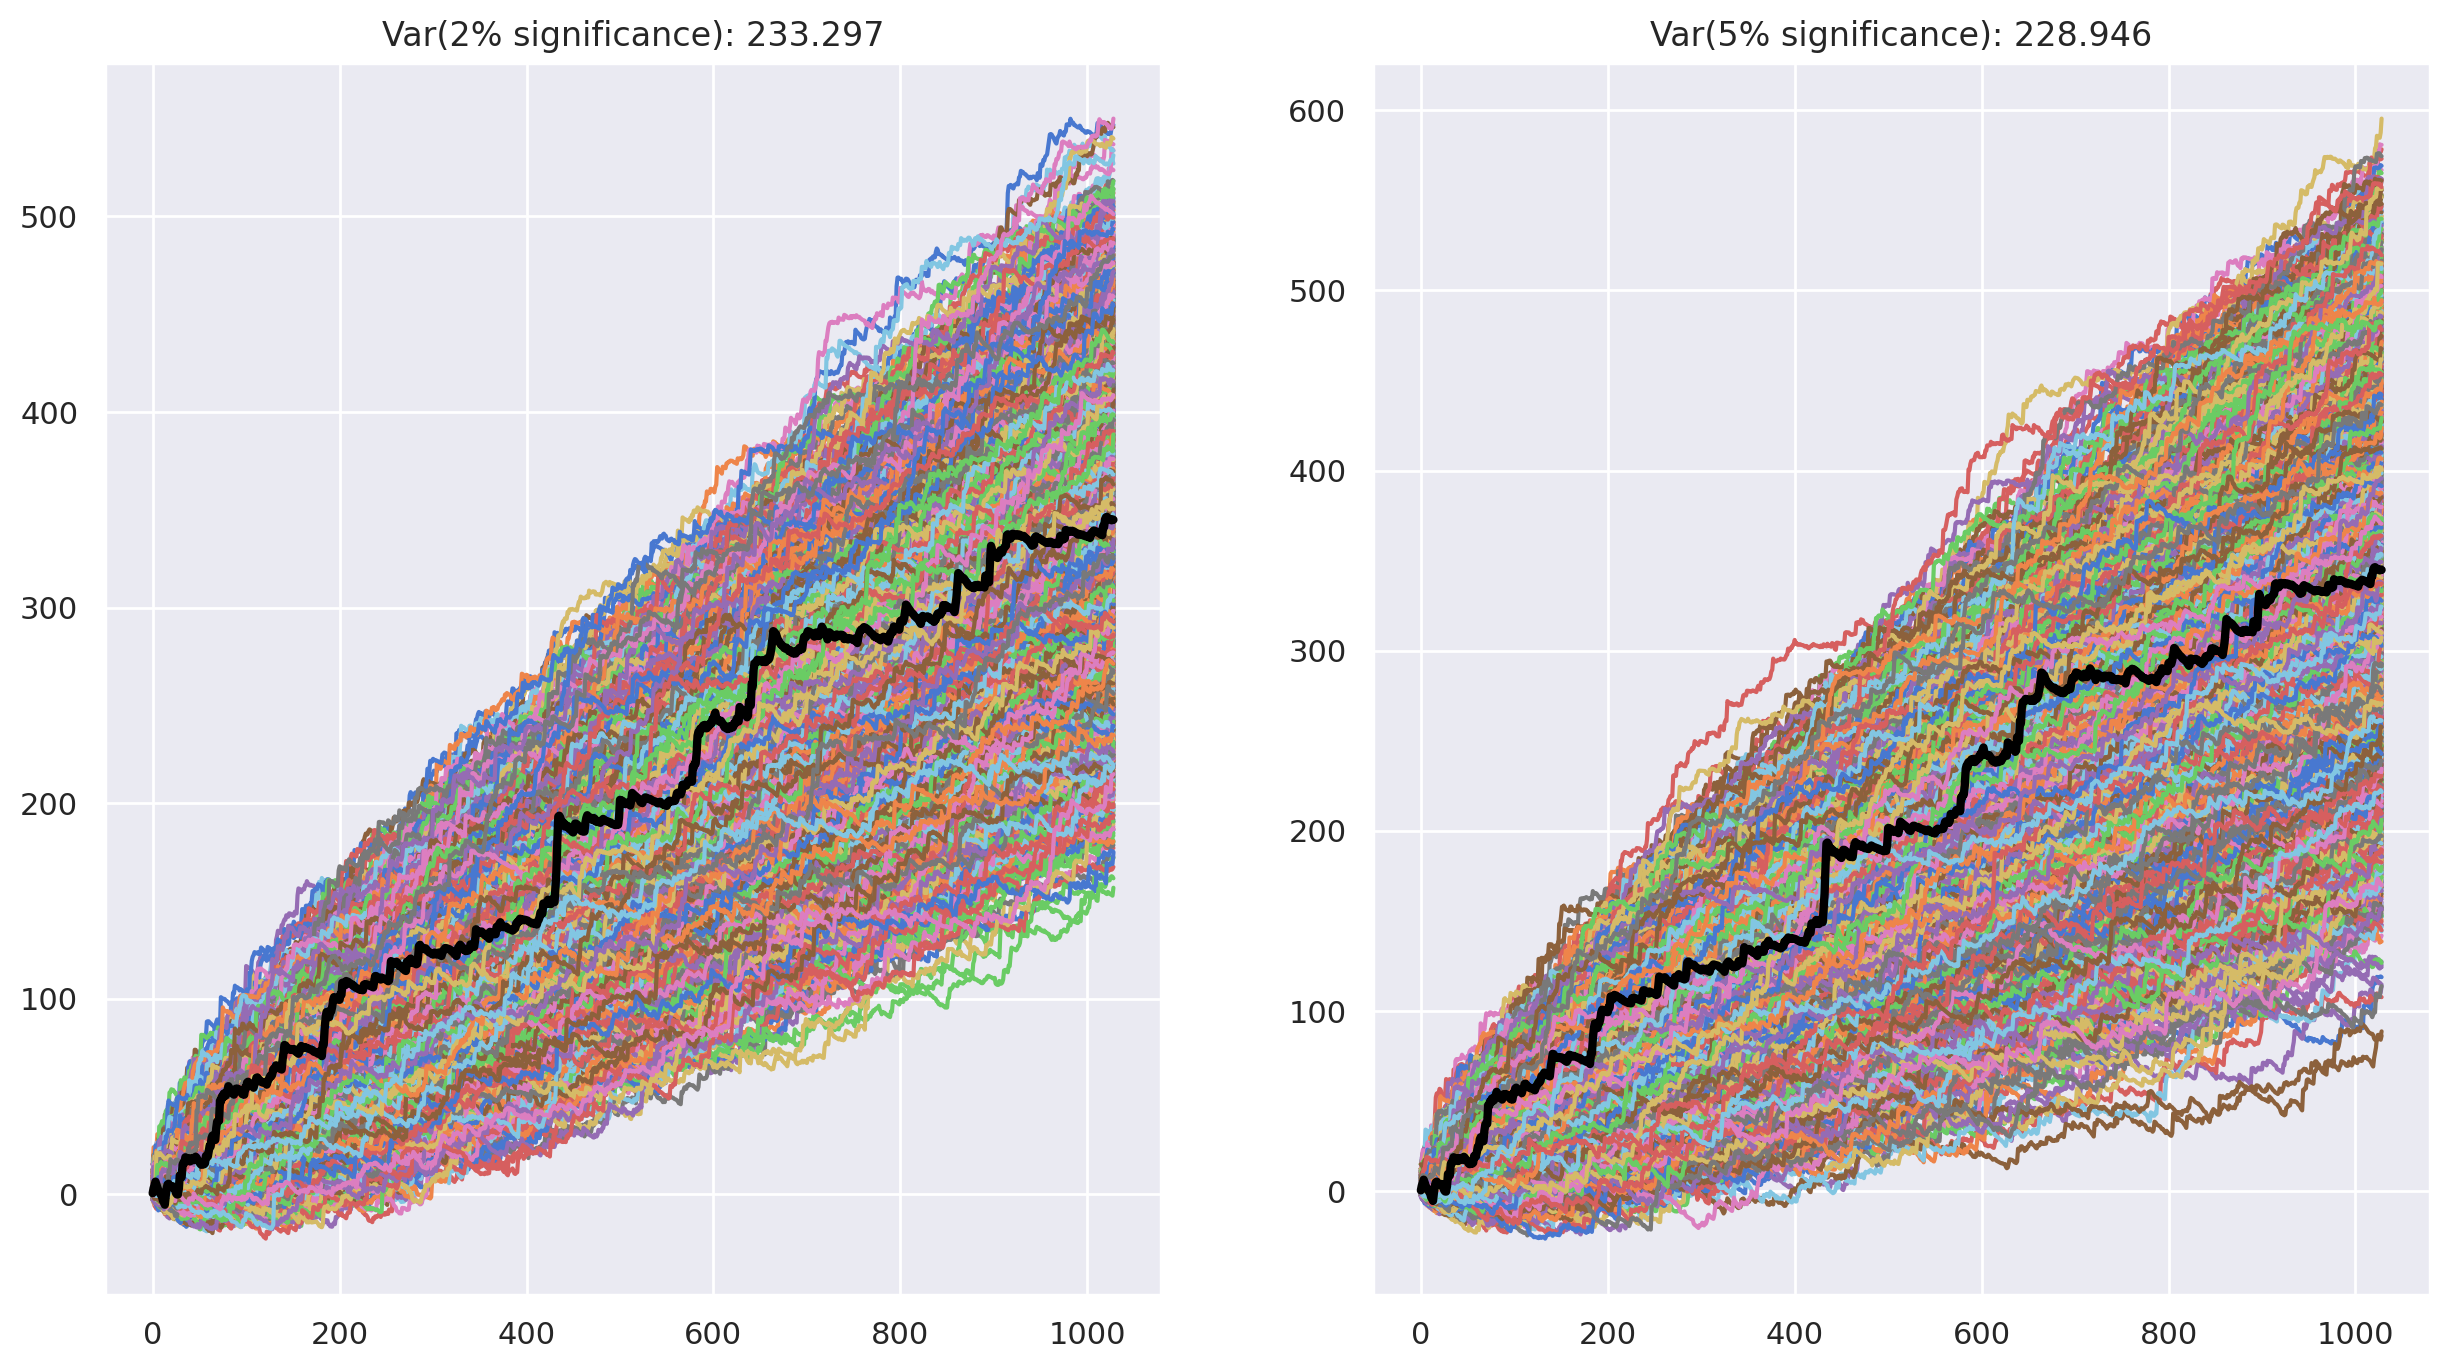

In [119]:
_seed(123)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(15, 8))

first_sim, first_var = simulate(backtest['uniformPnl'], M=10000, bins=200, significance=100-98)
ax.plot(first_sim)
ax.plot(backtest['uniformPnl'].cumsum(), color='black', linewidth=3)
ax.set(title=f"Var(2% significance): {first_var}")

second_sim, second_var = simulate(backtest['uniformPnl'], M=10000, bins=50, significance=100-95)

bx.plot(second_sim)
bx.plot(backtest['uniformPnl'].cumsum(), color='black', linewidth=3)
_ = bx.set(title=f"Var(5% significance): {second_var}")